# Preface:
First of all, prerequired modules and packages are imported 
and the default options for plot are set.

In [1]:
import time
import warnings
import pickle
import io, requests, zipfile
#####
import numpy as np
#from numba import jit, prange
import pandas as pd
import matplotlib.pyplot as plt
import qutip as Q
#####
from scipy.optimize import minimize
from scipy.stats import expon
#####
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler ,scale
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.decomposition import PCA
#####
from sklearn.model_selection import train_test_split ,  cross_val_score , cross_validate, learning_curve## only one split, cv split only scores, cv split scores and more info, cross_validate on different train_sizes
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV , validation_curve # on params
#####
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#####
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
#####
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBClassifier
#from mlxtend.classifier import StackingClassifier
#####
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix,  classification_report #cnfmatrix = confusion_matrix(Y,predicted_Y)
from sklearn.metrics import precision_recall_curve , roc_curve

In [2]:
'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 3 )

plt.rc('lines', markersize = 5 )

plt.rc('figure', figsize=(8,4) )         # Image size

warnings.filterwarnings("ignore") #ignore warnings

# Data Generation :

The method used for data generation is to use qutip module and generate a Random Density Matrice and then Calculate the 
Measurements on the Generated Density Matrice 


by calculating the determinant of the parital transposed density matrix, it can be de decided whether the state is entangled or not.

The matrix of features is in the form:

 $$Features = \begin{bmatrix}
\sigma_x\otimes\sigma_x & \sigma_x\otimes\sigma_y & \sigma_x\otimes\sigma_z & \sigma_x\otimes\ \mathbb{1} 
\\ \sigma_y\otimes\sigma_x & \sigma_y\otimes\sigma_y & \sigma_y\otimes\sigma_z & \sigma_y\otimes\ \mathbb{1}
\\ \sigma_z\otimes\sigma_x & \sigma_z\otimes\sigma_y & \sigma_z\otimes\sigma_z & \sigma_z\otimes\ \mathbb{1}
\\ \mathbb{1}\otimes\sigma_x & \mathbb{1}\otimes\sigma_y & \mathbb{1}\otimes\sigma_z & \mathbb{1}\otimes\ \mathbb{1}
\end{bmatrix}$$

The features are then reformed to (15 , 1) shape where $$ \mathbb{1} \otimes \mathbb{1} $$ feature is ommited since it's always 1.


The following function 'data_gen' recieves 'N' of type int, the number of samples to generate, and 'verbose' of type int, the vorbosity to report during generation.

return type is a DataFrame contains N records of random density matrices and contains following fields:

-15 features for the density matrix

-the PPT criterion, which is the determinant of the partial transpose of the bi-partite system. The PPT criterion says that if this value is negative, then the density matrix is entangled and if positive, then it is seprable

-the binary class of these matrices, where label '1' is for entangled matrices and '0' denotes the class of seprable matrices.

In [3]:
# (Number of samples (int)) -> (x,y,yc)
#O(n) , 10000 = 40s
def data_gen(N = 50000, verbose = -1):
  tim = time.time()
  sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
  f = np.empty((4,4))
  x = np.empty((N,15))
  y = np.empty(N)
  yc = np.empty(N,dtype=np.int64)

  for k in range(N):
    rho1 = Q.rand_dm(4,dims=[ [2,2] , [2,2] ] )
    for i in range(4):
      for j in range(4):
        f[i,j] = (rho1* Q.tensor(sigma[i],sigma[j])).tr().real
    x[k] = np.delete(f.reshape(1,16),15)
    rho2 = Q.partial_transpose(rho1, [0,1] )
    y[k] = np.linalg.det(rho2.full()).real
    if y[k] < 0 :
      yc[k]=1 #Entangled
    else:
      yc[k]=0 #Separable
    if (k+1) % (N/verbose) == 0 : print('Number of data generated : {}   , time elapsed : {} min , {} sec'.format(k+1,
                                                                                                                  int(time.time()-tim)//60,
                                                                                                                  int(time.time()-tim)%60) )  
  y=y.reshape(N,1)

  operators = ('sigma_x' , 'sigma_y' , 'sigma_z' , 'I' )
  columns = ['{} {}'.format(i,j) for i in operators for j in operators]
  del columns[-1]
  xd = pd.DataFrame(x,columns=columns)
  yd = pd.DataFrame(y,columns=['determinant'])
  ycd = pd.DataFrame(yc,columns=['is_entangled'])
  return pd.concat([xd,yd,ycd],axis=1)

## Generating and Saving / Loading the Data : 

we can generate and save the data in the following code:

In [4]:
# you can regenerate the data running this code 
n_samples=10000
data = data_gen(N=n_samples , verbose = 10)  
data.to_pickle('data.gz')
data.head()

Number of data generated : 1000   , time elapsed : 0 min , 6 sec
Number of data generated : 2000   , time elapsed : 0 min , 13 sec
Number of data generated : 3000   , time elapsed : 0 min , 18 sec
Number of data generated : 4000   , time elapsed : 0 min , 24 sec
Number of data generated : 5000   , time elapsed : 0 min , 30 sec
Number of data generated : 6000   , time elapsed : 0 min , 35 sec
Number of data generated : 7000   , time elapsed : 0 min , 41 sec
Number of data generated : 8000   , time elapsed : 0 min , 47 sec
Number of data generated : 9000   , time elapsed : 0 min , 53 sec
Number of data generated : 10000   , time elapsed : 0 min , 59 sec


,sigma_x sigma_x,sigma_x sigma_y,sigma_x sigma_z,sigma_x I,sigma_y sigma_x,sigma_y sigma_y,sigma_y sigma_z,sigma_y I,sigma_z sigma_x,sigma_z sigma_y,sigma_z sigma_z,sigma_z I,I sigma_x,I sigma_y,I sigma_z,determinant,is_entangled
0,0.000000,0.000000,-0.372468,0.106869,0.000000,0.000000,0.376746,0.216340,0.000000,0.000000,0.551017,-0.075678,0.000000,0.000000,0.000000,0.000483,0
1,-0.271983,0.054370,0.149609,-0.149609,0.054370,0.271983,-0.556913,0.556913,0.124510,0.599193,-0.100532,0.607391,0.124510,0.599193,-0.493141,-0.000957,1
2,-0.013298,0.053531,0.000000,0.000000,-0.145296,0.137528,0.000000,0.000000,0.391467,0.313045,-0.290443,0.477692,0.391467,0.313045,-0.258673,0.000641,0
3,-0.030880,0.074610,-0.059318,-0.059318,0.265594,-0.039266,0.019197,0.019197,-0.100327,0.344931,-0.108077,-0.457929,0.103206,-0.341260,0.154687,0.001242,0
4,-0.446482,-0.468198,0.029567,-0.029567,0.147302,-0.154572,0.078003,-0.078003,0.000000,0.000000,0.032528,0.407308,0.000000,0.000000,0.281180,-0.000581,1


In [5]:
# or you can Load the already saved data
data = pd.read_pickle('data.gz')
data.head()

,sigma_x sigma_x,sigma_x sigma_y,sigma_x sigma_z,sigma_x I,sigma_y sigma_x,sigma_y sigma_y,sigma_y sigma_z,sigma_y I,sigma_z sigma_x,sigma_z sigma_y,sigma_z sigma_z,sigma_z I,I sigma_x,I sigma_y,I sigma_z,determinant,is_entangled
0,0.000000,0.000000,-0.372468,0.106869,0.000000,0.000000,0.376746,0.216340,0.000000,0.000000,0.551017,-0.075678,0.000000,0.000000,0.000000,0.000483,0
1,-0.271983,0.054370,0.149609,-0.149609,0.054370,0.271983,-0.556913,0.556913,0.124510,0.599193,-0.100532,0.607391,0.124510,0.599193,-0.493141,-0.000957,1
2,-0.013298,0.053531,0.000000,0.000000,-0.145296,0.137528,0.000000,0.000000,0.391467,0.313045,-0.290443,0.477692,0.391467,0.313045,-0.258673,0.000641,0
3,-0.030880,0.074610,-0.059318,-0.059318,0.265594,-0.039266,0.019197,0.019197,-0.100327,0.344931,-0.108077,-0.457929,0.103206,-0.341260,0.154687,0.001242,0
4,-0.446482,-0.468198,0.029567,-0.029567,0.147302,-0.154572,0.078003,-0.078003,0.000000,0.000000,0.032528,0.407308,0.000000,0.000000,0.281180,-0.000581,1


In [6]:
x = data.drop(['determinant','is_entangled'],axis=1).values
y = data['determinant'].values
yc = data['is_entangled'].values
n_features=15

# Data Analysis : 

## Frequency of entangled states

In [7]:
# now we want to Calculate the percent of data which is entangled            
print("{} % of the stored data is entangled ".format(100*(yc.sum())/yc.size))

69.1 % of the stored data is entangled 


## Histograms :
The histograms of each 15 features are shown in the following figure

'Histogram'

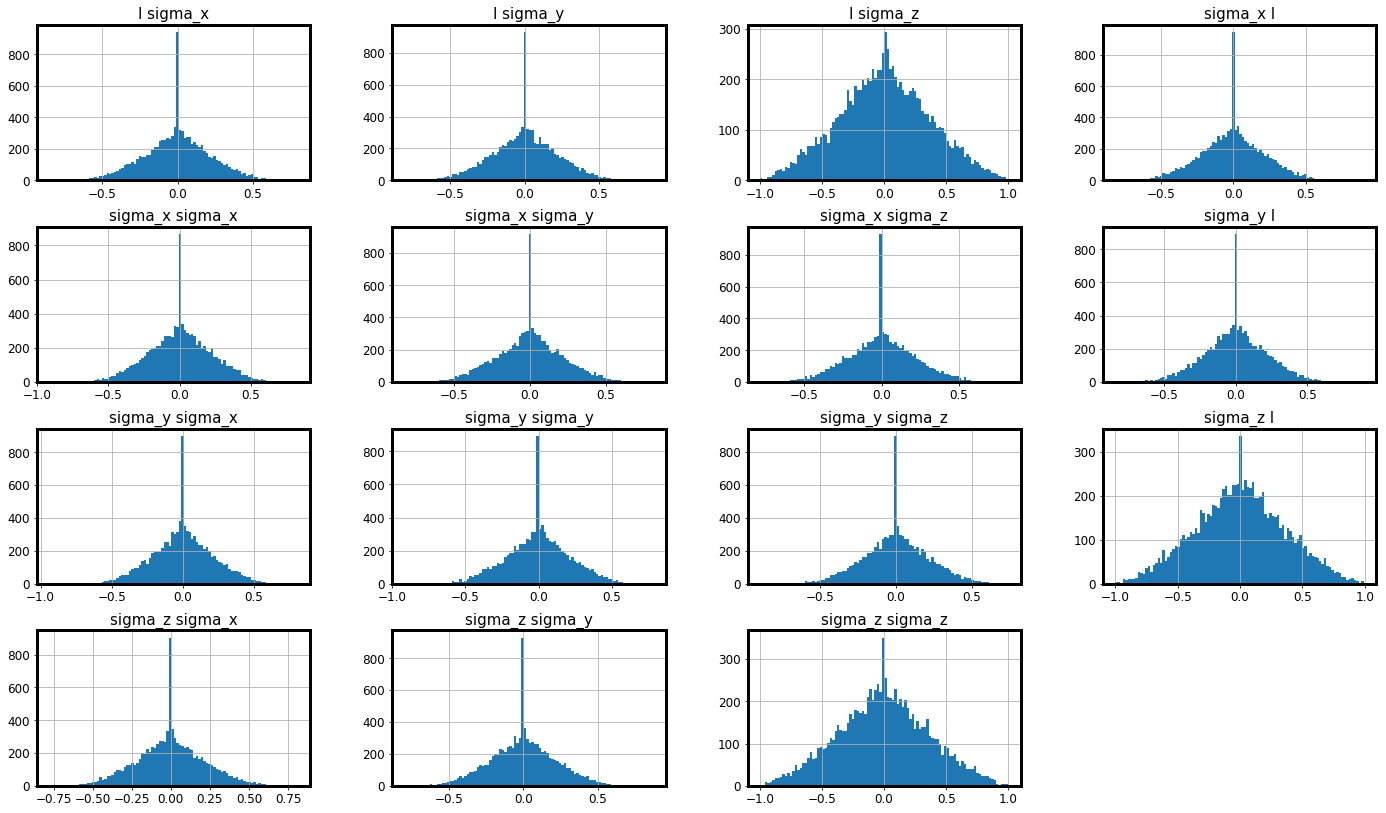

In [8]:
data.drop(['determinant','is_entangled'],axis=1).hist(figsize=(24,14),bins=100)
'Histogram'



There is an issue about the rand_dm method in qutip module, which it doesn't generate symmetric random matrices in each x,y and z direction. It could be easily found from the histogram of these 15 features, where distributions in correspondance to z axis are different from ones to x and y axes.

## Entanglement and Features :

in this part we plot the Determinant of Partial Transposed Density Matrix vs.Features

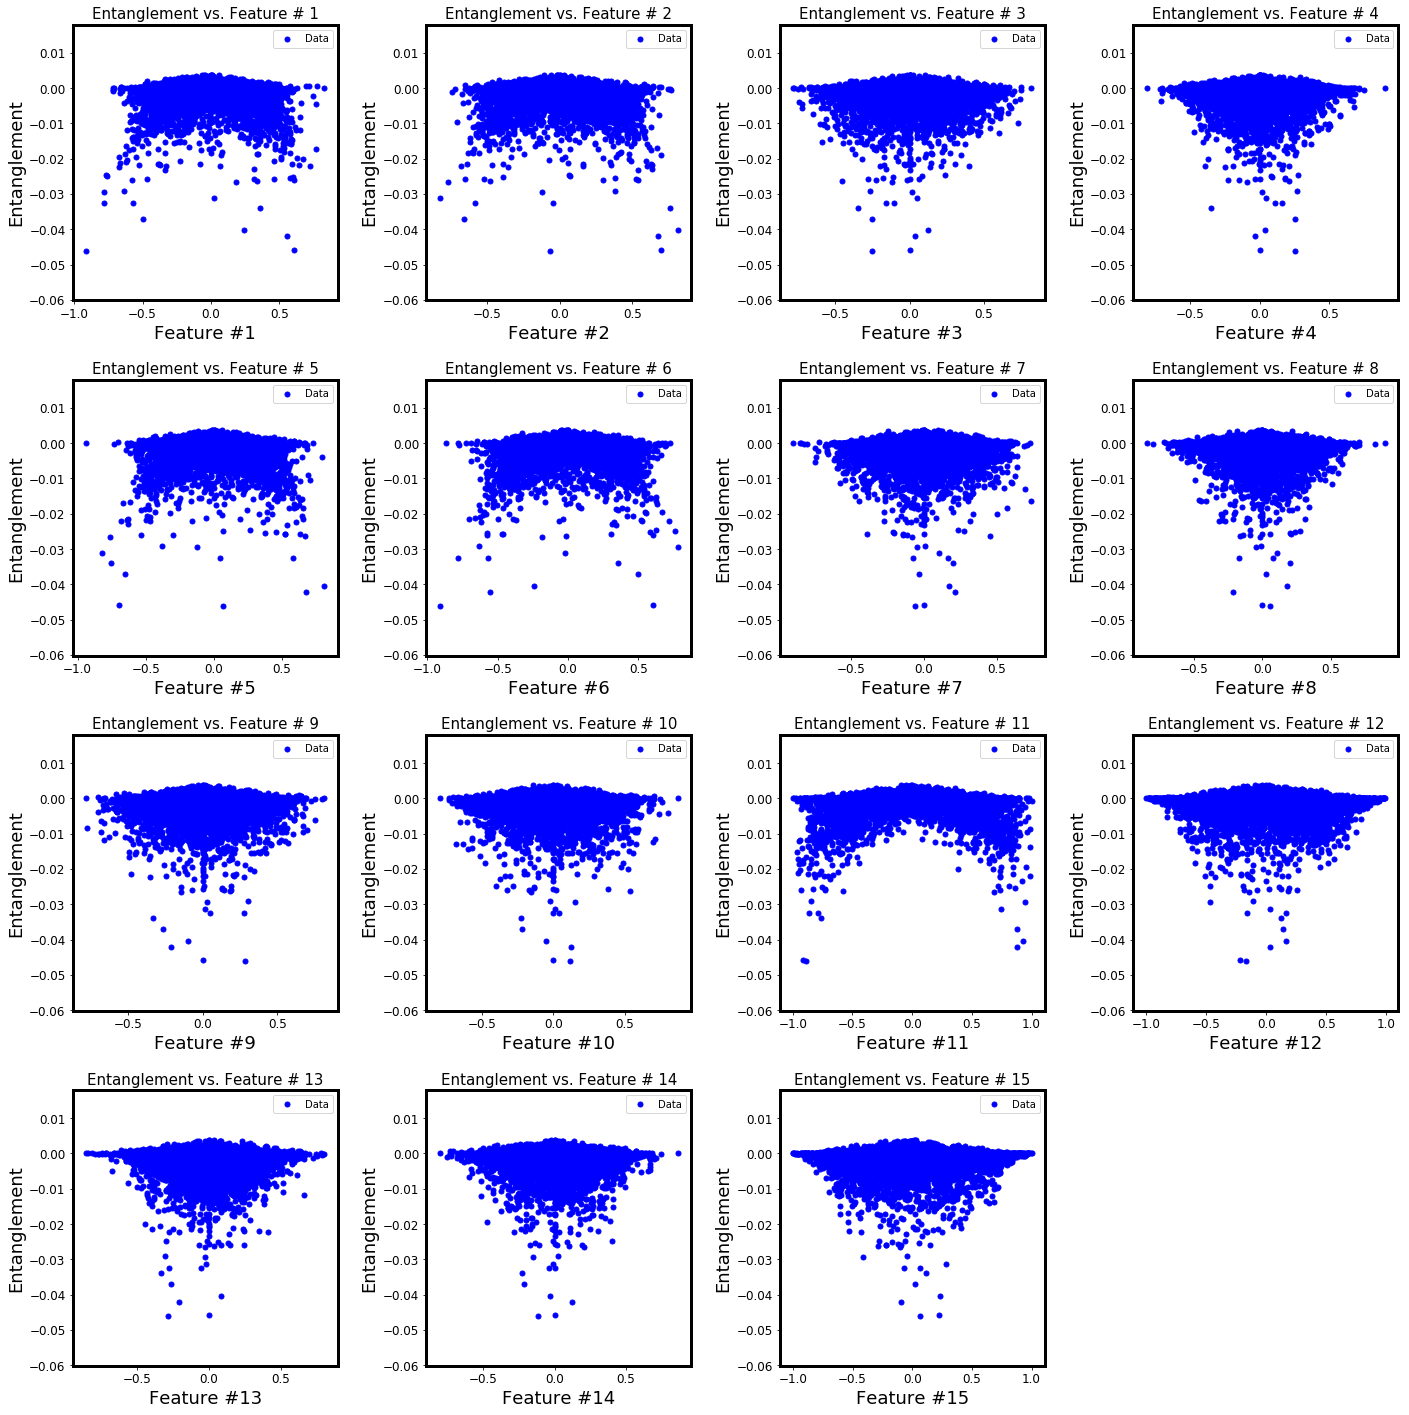

In [9]:
# without Classification
    
f = plt.figure(figsize=(20,20))
for i in range(15):
    ax = f.add_subplot(4, 4, i + 1, xlabel="Feature #" + str(i+1), ylabel='Entanglement', title="Entanglement vs. Feature # "+ str(i+1) )
    ax.scatter(x[:, i ] , y, color='b',label='Data' )
    ax.legend(loc=0, fontsize = 10)
    
plt.tight_layout()
plt.show()

the same problem about unsymmetry in x,y and z direction is also evident in above

## Ploting Features vs. Features :
in this section one selected feature can be plotted against the Other Features 

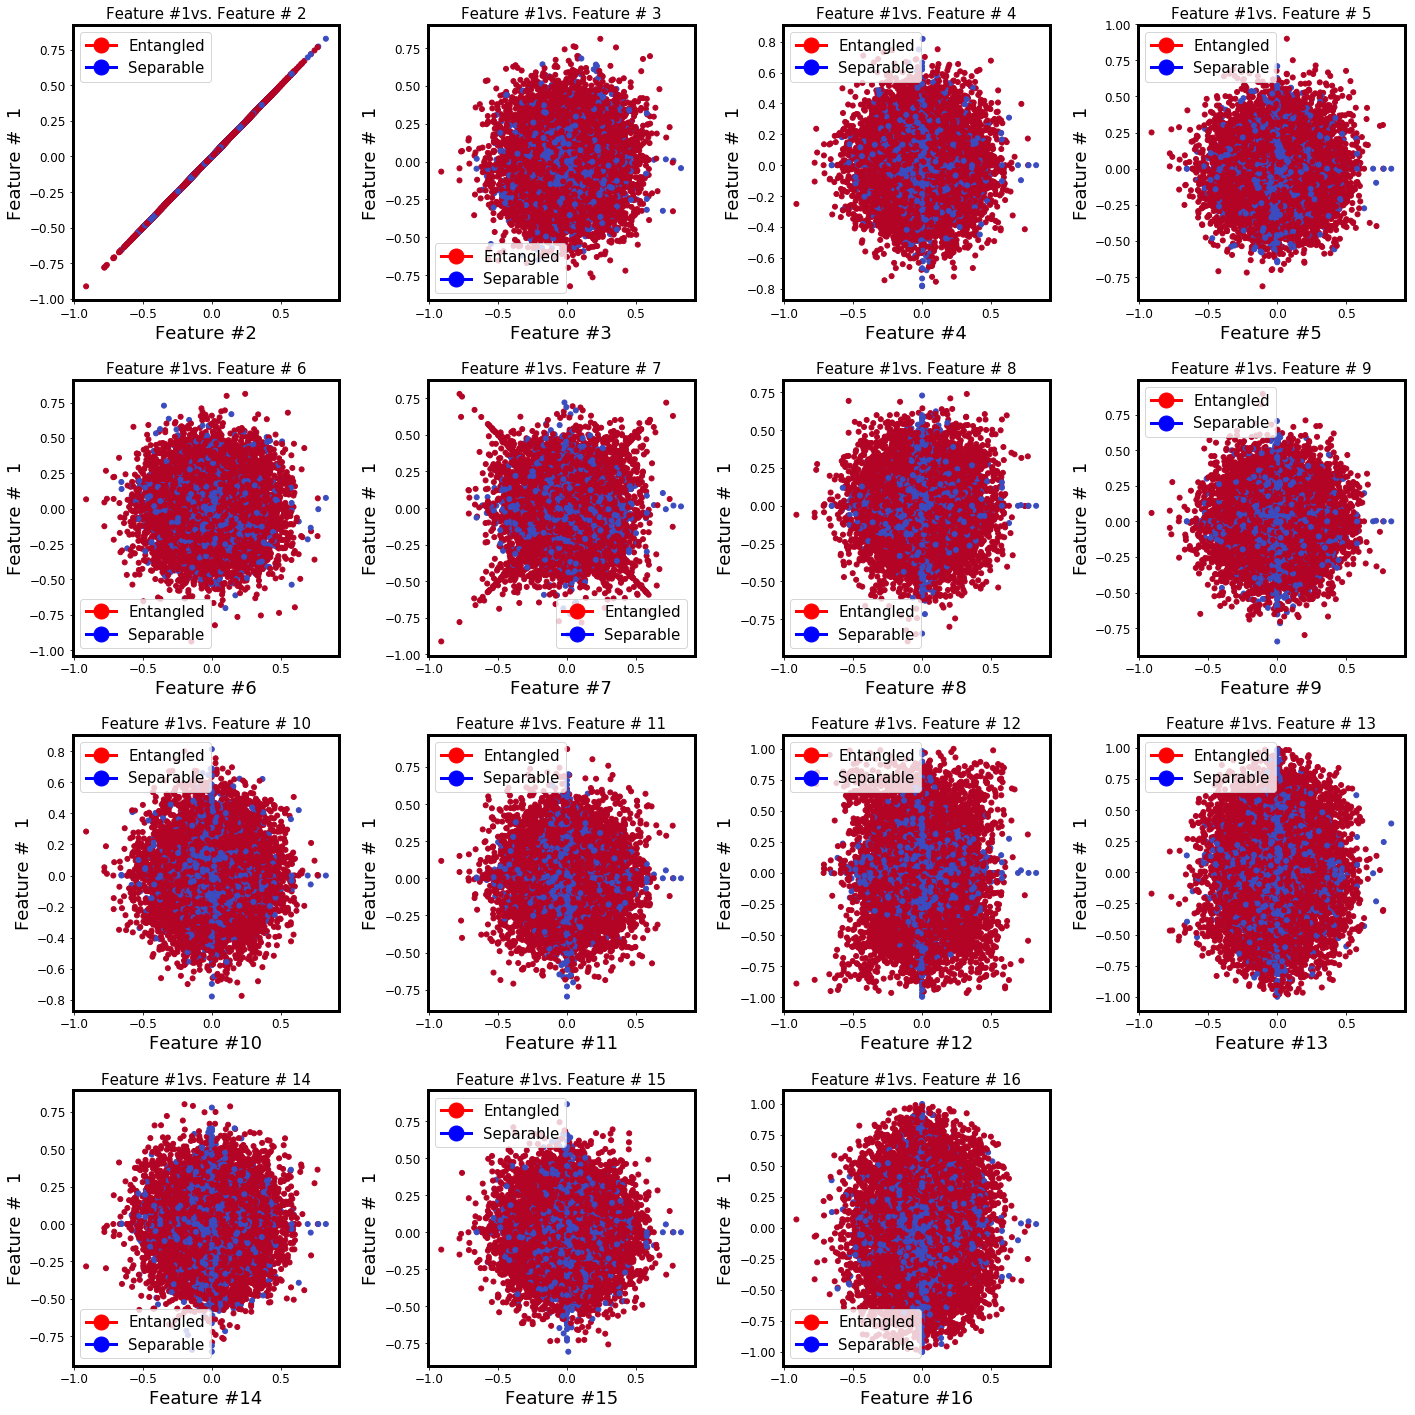

CPU times: user 24.3 s, sys: 9.79 s, total: 34.1 s
Wall time: 20.4 s


In [10]:
%%time
# with Classification Mode
sel = 0 # you can change this variable and change the selected fearue 
# the order of stored features is
# (Sx*Sx  Sx*Sy  Sx*Sz  Sx*I  )
# (Sy*Sx  Sy*Sy  Sy*Sz  Sy*I  )
# (Sz*Sx  Sz*Sy  Sz*Sz  Sz*I  )
# ( I*Sx   I*Sy   I*Sz   I*I  )

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker = 'o' , color='r' , markerfacecolor='r', markersize=15),
                Line2D([0], [0], marker = 'o' , color='b' , markerfacecolor='b', markersize=15)]

f = plt.figure(figsize=(20,20))
for i in range(15):
    ax = f.add_subplot(4, 4, i + 1, xlabel="Feature #" + str(i+2), ylabel='Feature #  '+str(sel+1), title="Feature #" +str(sel+1) + "vs. Feature # "+ str(i+2) )
    ax.scatter(x[:,sel],x[:,i], c= yc , cmap=plt.cm.coolwarm )
    ax.legend(custom_lines, ['Entangled', 'Separable'])    

plt.tight_layout()
plt.show()

## Histograms of Entangeld Data:

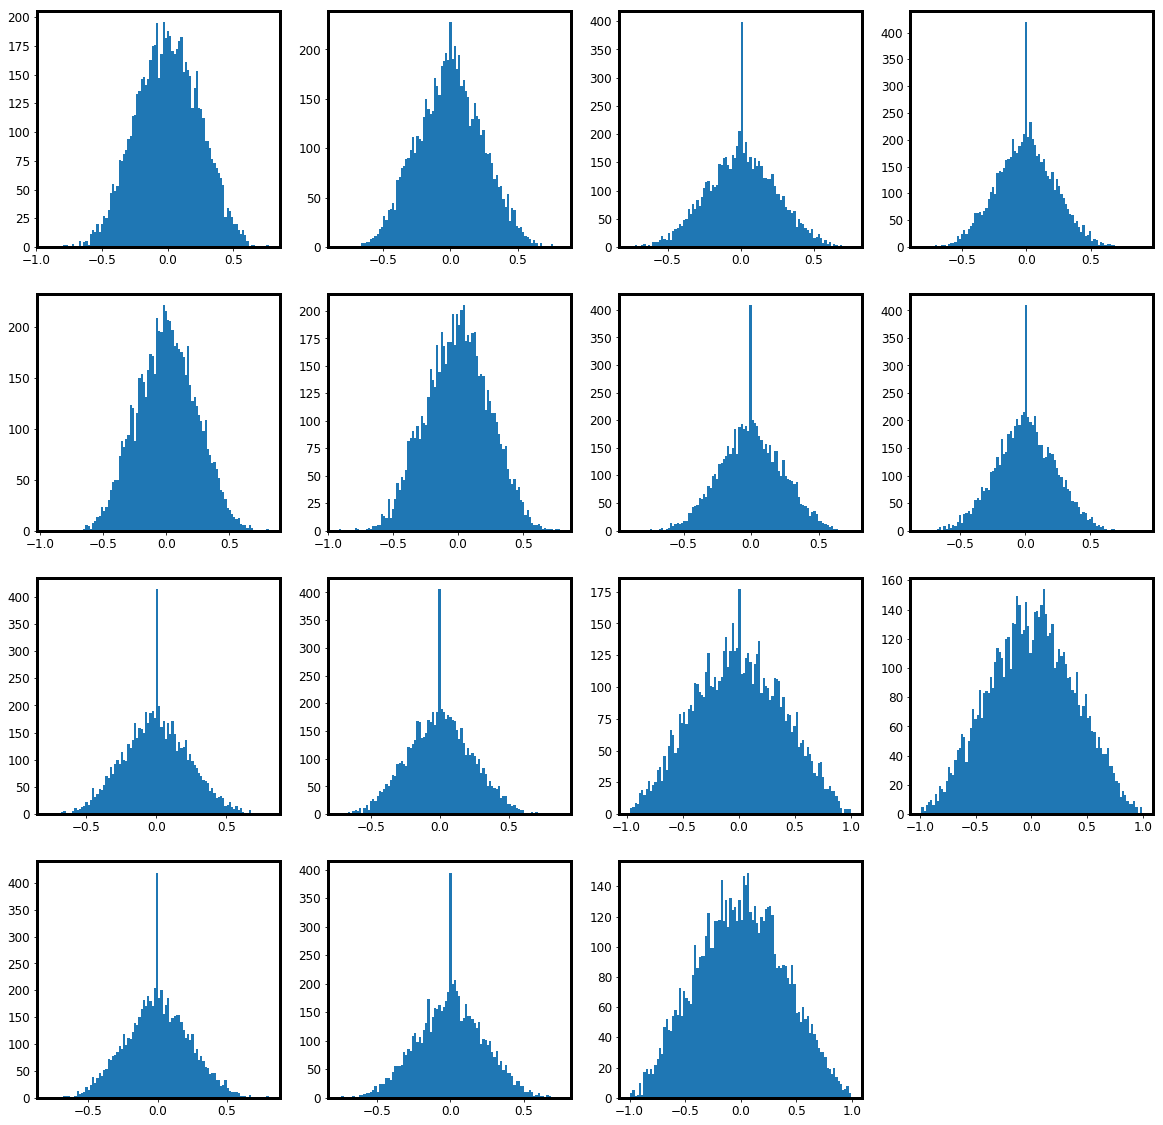

CPU times: user 7.77 s, sys: 2.6 s, total: 10.4 s
Wall time: 6.78 s


In [11]:
%%time
# Histograms
n_feature=15
dellist = []
dellistc = []
fig = plt.figure(figsize=(20,20))

for i in range (n_samples):
    if yc[i] == 1: dellistc.append(i)

for i in range (n_samples):
        if y[i] >= 0: dellist.append(i)


ent_x = np.delete( x , dellist , 0)
ent_y = np.delete( y , dellist , 0)
ent_yc = np.delete(yc,dellistc)
ax=[]
for i in range(n_feature) :
    ax.append( fig.add_subplot(4,4,i+1) )
    ax[i].hist(ent_x[:,i],bins=100)

plt.show()
#plt.tight_layout()
plt.close()


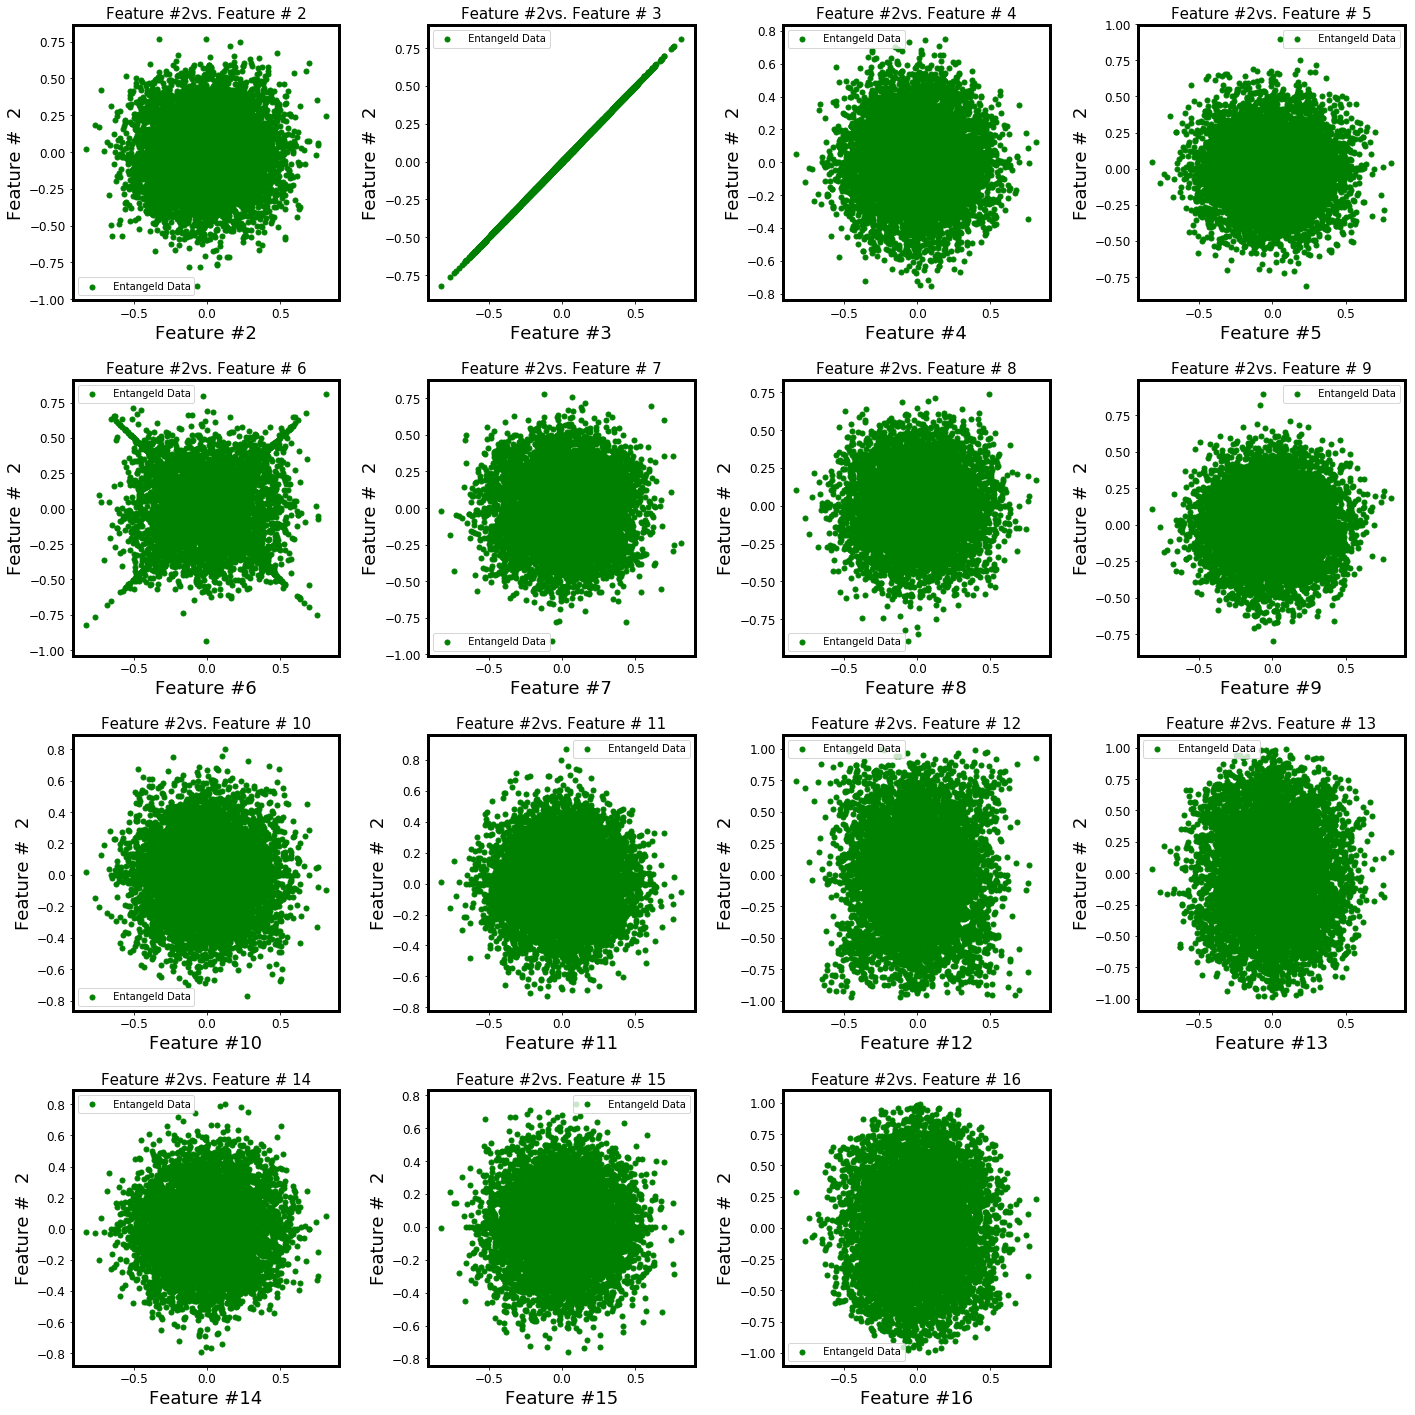

In [12]:
#  Entangled Data
sel = 1

f = plt.figure(figsize=(20,20))
for i in range(n_feature):
    ax = f.add_subplot(4, 4, i + 1, xlabel="Feature #" + str(i+2), ylabel='Feature #  '+str(sel+1), title="Feature #" +str(sel+1) + "vs. Feature # "+ str(i+2) )
    ax.scatter(ent_x[:, sel ] ,ent_x[:, i], color='g',label=' Entangeld Data' )
    ax.legend(loc=0, fontsize = 10)
    
plt.tight_layout()
plt.show()

## Correlation between Features : 

in the following section We calculate the Pearson correlation coefficient for each data to see how Correlated the Data is :

the Pearson correlation coefficient between two values can be calculated using the following formula :

$$ {\rho _x}_ y =\ \frac{COV (X , Y)}{\sigma_x \times \sigma_y} =\ \frac{E[(X-\mu_x)(Y-\mu_y)]}{\sigma_x \times \sigma_y} $$

after calculating the Pearson Correlation Coefficient , we show which Coefficient is bigger :

In [13]:
%%time
# calculating correlation between data :
cor_data = np.empty((n_feature,n_feature))
for i in range (n_feature):
    for j in range (n_feature):
        if i==j:
            cor_data[i , j]= 0
            continue
        else:
            cov  = np.mean(x[:,i]*x[:,j]) - (np.mean(x[:,i])*(np.mean(x[:,j])))
            stds = ((np.std(x[:,i]) )* (np.std(x[:,j])))
            cor_data[i , j]= np.abs(cov/stds)


cor_pd = pd.DataFrame(cor_data)
print (cor_pd.idxmax())

0      1
1      4
2      3
3     14
4      1
5      3
6      7
7      6
8     12
9     13
10     1
11    13
12     1
13     9
14     3
dtype: int64
CPU times: user 56 ms, sys: 3.02 ms, total: 59.1 ms
Wall time: 57.6 ms


# Data Preparation /  Reduction :

## Data Cleanup
Our data is cleaned up by itself, because it is synthetically generated, so there isn't any missing data and the class values are binary numeric values '0' and '1'.

## Data Scaling
the data has been scaled by three different scalers (StandardScaler, MinMaxScaler and RobustScaler). Then each scaled data are going to be given to different regressors and classifiers.

In [14]:
X_scaled = scale(x) 

s_scaler = StandardScaler()
X_sscaled = s_scaler.fit_transform(x) 

mm_scaler = MinMaxScaler()
mm_scaler.fit(x)
X_mmscaled = mm_scaler.transform(x) 

r_scaler = RobustScaler()
r_scaler.fit(x)
X_rscaled = r_scaler.transform(x) 

## Spliting Train and Test from data :

In [15]:
X_train , X_test , Y_train , Y_test  = train_test_split(x , y , random_state = 0)

Xs_train , Xs_test , Ys_train , Ys_test  = train_test_split(X_scaled , y , random_state = 0)

Xm_train , Xm_test , Ym_train , Ym_test  = train_test_split(X_sscaled , y , random_state = 0)

Xst_train , Xst_test , Yst_train , Yst_test  = train_test_split(X_mmscaled , y , random_state = 0)

Xr_train , Xr_test , Yr_train , Yr_test  = train_test_split(X_rscaled , y , random_state = 0)

# Regression Method : 

using Cross Validation for the following regression Methods :
1. Linear Regression
2. Decision Tree Regressor
3. Support Vector Machine

### Linear Regression using PolyFeatures (degree=4)

In [16]:
%%time
polytransform = PolynomialFeatures(degree=4 )
reg_nl2 = LinearRegression()
reg_nl2.fit(       (polytransform.fit_transform(X_train))      , Y_train)

CPU times: user 3min 44s, sys: 28.5 s, total: 4min 13s
Wall time: 36 s


In [17]:
%%time
print( "the accuracy of Linear Regression is : {} ".format(reg_nl2.score(polytransform.fit_transform(X_test), Y_test)))

the accuracy of Linear Regression is : 1.0 
CPU times: user 588 ms, sys: 435 ms, total: 1.02 s
Wall time: 437 ms


in consideration of Data size we dont run cross validation for Linear Regression because of runtime 

### Decision Tree Regressor : 

In [18]:
%%time
tree_reg = DecisionTreeRegressor(max_depth = 8)
tree_reg.fit(X_train,Y_train)
print( "the score on Training Data is {}" .format(tree_reg.score(X_train,Y_train)) )
print( "the score on test Data is {}".format(tree_reg.score(X_test,Y_test)) )
print("the Important Feature of this Regressor is :{}".format(tree_reg.feature_importances_))

the score on Training Data is 0.7930800246493879
the score on test Data is 0.5912569025581828
the Important Feature of this Regressor is :[0.26337532 0.05989899 0.00946914 0.00161625 0.21423553 0.08608161
 0.01573829 0.0015443  0.01277815 0.01463867 0.30528123 0.00449651
 0.00136856 0.00388819 0.00558928]
CPU times: user 301 ms, sys: 492 ms, total: 793 ms
Wall time: 140 ms


#### using Cross Validation :

In [19]:
t_reg = DecisionTreeRegressor(max_depth=10)
tree_regscores = cross_validate(t_reg , x, y, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
t_scores = pd.DataFrame(tree_regscores)
print('The result on the original data is: \n {}'.format(  t_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time    test_score   train_score
mean  0.264323    0.001017 -4.222584e-06 -1.487703e-06
std   0.044067    0.000228  7.698308e-07  4.558350e-08


### SVR:

runtime of SVR for 100000 data is too long so we cant afford this run !

In [20]:
%%time
svr_nl = SVR(kernel='rbf',degree = 4, epsilon = 0.001 , gamma = 'auto' )
svr_nl.fit(X_train, Y_train )
print( "the score on Training Data is {}" .format(svr_nl.score(X_train,Y_train)) )
print( "the score on test Data is {}".format(svr_nl.score(X_test,Y_test)) )

the score on Training Data is 0.9067044314904097
the score on test Data is 0.8833874260445215
CPU times: user 9.35 s, sys: 28.9 ms, total: 9.38 s
Wall time: 9.37 s


In [21]:
# using a randomSearch for a better Reggression 


params_dist_SVR = {'C': expon(scale=100), 'gamma': expon(scale=.1),
  'kernel': ['rbf' , 'poly'] , 'epsilon': expon (scale = 0.01) }
svr_reg = SVR()

svr_reg_rs = RandomizedSearchCV(svr_reg, param_distributions=params_dist_SVR, cv=5, n_jobs=-1)

svr_reg_rs.fit(X_train, Y_train)
print(svr_reg_rs.best_params_)
print(svr_reg_rs.best_score_)

{'C': 11.130259730921326, 'epsilon': 0.001771728966205134, 'gamma': 0.05719925337122294, 'kernel': 'rbf'}
0.8737656399464506


# Classification Methods :
using Cross Validation for following Classification Methods :
1. Decision Tree Classifier
2. Ridge Classifier
3. bayes
4. SVC
5. SGD 

In [22]:
X_train , X_test , Y_train , Y_test  = train_test_split(x , yc , random_state = 0)

Xs_train , Xs_test , Ys_train , Ys_test  = train_test_split(X_scaled , yc , random_state = 0)

Xm_train , Xm_test , Ym_train , Ym_test  = train_test_split(X_sscaled , yc , random_state = 0)

Xst_train , Xst_test , Yst_train , Yst_test  = train_test_split(X_mmscaled , yc , random_state = 0)

Xr_train , Xr_test , Yr_train , Yr_test  = train_test_split(X_rscaled , yc , random_state = 0)

### Decision Tree Classifier :

In [23]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,Y_train)

print("The accuracy of the tree classifier is: {}".format( tree_clf.score(X_train,Y_train) ) )
print("The accuracy of the tree classifier is: {}".format( tree_clf.score(X_test,Y_test) ) )

The accuracy of the tree classifier is: 1.0
The accuracy of the tree classifier is: 0.7528


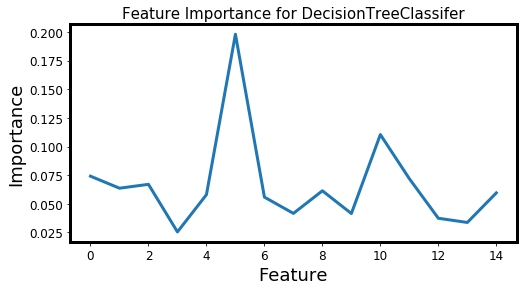

In [24]:
plt_title = 'Feature Importance for DecisionTreeClassifer'
x_label = 'Feature'
y_label = 'Importance'
fig = plt.figure()
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)

ax.plot(  tree_clf.feature_importances_  )
plt.show()

In [25]:
#cross Validation 
t_clf = DecisionTreeClassifier(max_depth=10)
tree_clfscores = cross_validate(t_clf , x, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
t_c_scores = pd.DataFrame(tree_clfscores)
print('The result on the original data is: \n {}'.format(  t_c_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  0.215161    0.000783   -0.252900    -0.152722
std   0.036250    0.000149    0.015169     0.009146


## Random Forest :

In [64]:
rdm_fo = RandomForestClassifier(n_estimators = 100)
rdm_fo.fit(X_train , Y_train)
print(rdm_fo.score(X_train , Y_train))
print(rdm_fo.score(X_test , Y_test))

1.0
0.8376


In [27]:
rdmf_clf = RandomForestClassifier(n_estimators = 100)
rdmfI_clfscores = cross_validate(rdmf_clf , x, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
rdmfI_scores = pd.DataFrame(rdmfI_clfscores)
print('The result on the original data is: \n {}'.format(  rdmfI_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  4.568702    0.047225   -0.173000          0.0
std   0.916850    0.010834    0.008628          0.0


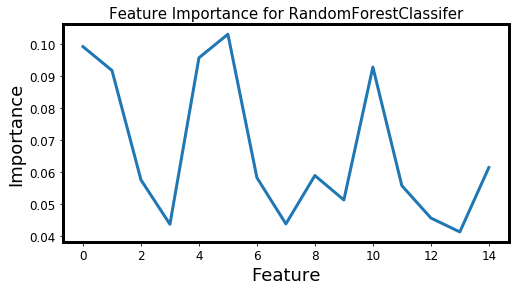

In [65]:
plt_title = 'Feature Importance for RandomForestClassifer'
x_label = 'Feature'
y_label = 'Importance'
fig = plt.figure()
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)

ax.plot(  rdm_fo.feature_importances_  )
plt.show()

In [69]:
argss=np.argsort(rdm_fo.feature_importances_)[::-1]
print('top most important features are sorted:\n'+str(argss))
print('with corresponding importance of :\n'+str(rdm_fo.feature_importances_[argss]))

top most important features are sorted:
[ 5  0  4 10  1 14  8  6  2 11  9 12  7  3 13]
with corresponding importance of :
[0.10311156 0.09922985 0.09573849 0.09285542 0.09178012 0.06138772
 0.05890035 0.05822002 0.05753197 0.05572869 0.0512534  0.04561271
 0.04375722 0.04364266 0.04124982]


so the top most important features are around 0.95:

sigma_y sigma_y

sigma_x sigma_x

sigma_y sigma_x

sigma_z sigma_z

then:

I sigma_y

sigma_y I

sigma_y sigma_z

...


## Ridge Classifier :

In [29]:
polytransform = PolynomialFeatures(degree=4 )
lrg = RidgeClassifier()
lrg.fit( (polytransform.fit_transform(X_train)) , Y_train)
print(lrg.score( (polytransform.fit_transform(X_train)) , Y_train ))
print(lrg.score( (polytransform.fit_transform(X_test)) , Y_test ))

0.8764
0.8516


In [30]:
ridge_clf = RidgeClassifier()
ridge_clfscores = cross_validate(ridge_clf , x, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=5)
ridge_scores = pd.DataFrame(ridge_clfscores)
print('The result on the original data is: \n {}'.format(  ridge_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  0.030344    0.003738      -0.309       -0.309
std   0.004859    0.000503       0.000        0.000


## SVC : 

because of the data size we can't afford this run !.

In [31]:
svc_clf = SVC(kernel='rbf',degree = 4, gamma = 'auto')
svc_clf.fit(X_train,Y_train )
svc_clf.score(X_test , Y_test)

0.7224

In [32]:
# using a randomSearch for a better Classification 

params_dist = {'C': expon(scale=100), 'gamma': expon(scale=.1),
  'kernel': ['rbf' , 'poly']}
svc_clf1 = SVC()

svc_clf1_rs = RandomizedSearchCV(svc_clf1, param_distributions=params_dist, cv=5, n_jobs=-1)

svc_clf1_rs.fit(X_train, Y_train)
print(svc_clf1_rs.best_params_)
print(svc_clf1_rs.best_score_)

{'C': 190.11178773889966, 'gamma': 0.24063335712882059, 'kernel': 'rbf'}
0.8613333333333333


In [34]:
svcI_clf = SVC()
svcI_clfscores = cross_validate(svcI_clf , x, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
svcI_scores = pd.DataFrame(svcI_clfscores)
print('The result on the original data is: \n {}'.format(  svcI_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  9.239534    0.517843   -0.266000    -0.265444
std   2.297702    0.128411    0.007513     0.004786


## Bayes:

In [35]:
by_clf = GaussianNB()
by_clf.fit(Xr_train , Yr_train)
by_clf.score(Xr_test , Yr_test)

0.828

In [36]:
params_dist_b = {'priors' : [None ] , 'var_smoothing':expon(scale = 10**-5)}
by_clf1 = GaussianNB()

by_clf1_rs = RandomizedSearchCV(by_clf1, param_distributions=params_dist_b, cv=6, n_jobs=-1)

by_clf1_rs.fit(X_train, Y_train)
print(by_clf1_rs.best_params_)
print(by_clf1_rs.best_score_)

{'priors': None, 'var_smoothing': 5.513737005385675e-06}
0.8196


In [37]:
byI_clf = GaussianNB()
byI_clfscores = cross_validate(byI_clf , x, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
byI_scores = pd.DataFrame(byI_clfscores)
print('The result on the original data is: \n {}'.format(  byI_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  0.018034    0.001921   -0.176000    -0.176144
std   0.004440    0.000372    0.013325     0.001551


## SGD:

In [38]:
polytransform = PolynomialFeatures(degree=4 )

sgd_clf = SGDClassifier(max_iter=10, tol=.15)
sgd_clf.fit(polytransform.fit_transform(Xst_train),Yst_train)

print(sgd_clf.score(polytransform.fit_transform(Xst_test),Yst_test))

0.8056


In [39]:
# using a randomSearch for a better Classification 
params_dist_SGD = { 'penalty':['none', 'l2', 'l1'],
  'alpha':expon(scale = 0.001) , 'max_iter':[10 , 20 , 30 , 40 , 50 , 60 ] , 'tol' :expon(scale =0.001) , 'epsilon': expon(scale = 0.01) }
sgd_clf = SGDClassifier()

sgd_clf_rs = RandomizedSearchCV(sgd_clf, param_distributions=params_dist_SGD, cv=5, n_jobs=-1)

sgd_clf_rs.fit(X_train, Y_train)
print(sgd_clf_rs.best_params_)
print(sgd_clf_rs.best_score_)

{'alpha': 0.0003045364143624002, 'epsilon': 4.710173723706335e-05, 'max_iter': 10, 'penalty': 'none', 'tol': 0.0019102583416271514}
0.6865333333333333


In [41]:
sgdI_clf = SGDClassifier()
sgdI_clfscores = cross_validate(sgdI_clf , x, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
sgdI_scores = pd.DataFrame(sgdI_clfscores)
print('The result on the original data is: \n {}'.format(  sgdI_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  0.028218    0.033195   -0.332600    -0.335244
std   0.014006    0.030514    0.038728     0.043637


# Data Reduction using PCA :

In [42]:
n_c = 10  ## # components we want to keep. 
pca = PCA(n_components=n_c)
pca.fit(Xr_train)

reduced_Xr_train = pca.transform(Xr_train)
print (reduced_Xr_train.shape)

(7500, 10)


In [43]:
reduced_Xr_test = pca.transform(Xr_test)
redc_Xr_test = pca.inverse_transform(reduced_Xr_test)

redc_Xr_train = pca.inverse_transform(reduced_Xr_train)

In [44]:
pca_t = PCA(n_components=n_c)
pca_t.fit(x)

reduced_x = pca.transform(x)
redc_X = pca.inverse_transform(reduced_x)

## using Classification :

### Ridge Classifier:


In [45]:
polytransform = PolynomialFeatures(degree=4 )
lrg_1 = RidgeClassifier()
lrg_1.fit( (polytransform.fit_transform(redc_Xr_train)) , Y_train)
print(lrg_1.score( (polytransform.fit_transform(redc_Xr_train)) , Y_train ))
print(lrg_1.score( (polytransform.fit_transform(redc_Xr_test)) , Y_test ))

0.7988
0.7668


In [46]:
ridge_clf = RidgeClassifier()
ridge_clfscores = cross_validate(ridge_clf , redc_X, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
ridge_scores = pd.DataFrame(ridge_clfscores)
print('The result on the original data is: \n {}'.format(  ridge_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time    test_score   train_score
mean  0.022912    0.004467 -3.090000e-01 -3.090000e-01
std   0.021739    0.008716  5.851389e-17  5.851389e-17


### SGD:

In [47]:
sgdI_clf = SGDClassifier()
sgdI_clfscores = cross_validate(sgdI_clf , redc_X, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
sgdI_scores = pd.DataFrame(sgdI_clfscores)
print('The result on the original data is: \n {}'.format(  sgdI_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  0.020932    0.022227    -0.31330    -0.313611
std   0.014990    0.020289     0.01325     0.013668


### Bayes:

In [48]:
byII_clf = GaussianNB()
byII_clfscores = cross_validate(byII_clf , redc_X, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
byII_scores = pd.DataFrame(byII_clfscores)
print('The result on the original data is: \n {}'.format(  byII_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  0.012432    0.001850   -0.241100    -0.240167
std   0.002877    0.000483    0.012871     0.001890


### Random Forest

In [49]:
rdm_fo = RandomForestClassifier(n_estimators = 100)
rdm_fo.fit(redc_Xr_train , Y_train)
print(rdm_fo.score(redc_Xr_train , Y_train))
print(rdm_fo.score(redc_Xr_test , Y_test))

1.0
0.7896


In [50]:
rdmfII_clf = RandomForestClassifier(n_estimators = 200)
rdmfII_clfscores = cross_validate(rdmfII_clf ,  redc_X, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
rdmfII_scores = pd.DataFrame(rdmfII_clfscores)
print('The result on the reduced data is: \n {}'.format(  rdmfII_scores.describe().loc[['mean','std']] ) )

The result on the reduced data is: 
       fit_time  score_time  test_score  train_score
mean  9.199510    0.087231   -0.217800          0.0
std   1.798608    0.019204    0.007115          0.0


## Using Regression Method with reduced Data:

### Linear Regression:

In [ ]:
%%time 
polytransform1 = PolynomialFeatures(degree=4 )
reg_nl3 = LinearRegression()
reg_nl3.fit(       (polytransform1.fit_transform(redc_Xr_train))      , Yr_train)

In [ ]:
print (reg_nl3.score(polytransform1.fit_transform(redc_Xr_test) , Yr_test))

### Decision Tree Regressor:

In [ ]:
%%time 
t_reg = DecisionTreeRegressor(max_depth=10)
tree_regscores = cross_validate(t_reg , redc_X, y, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
t_scores = pd.DataFrame(tree_regscores)
print('The result on the original data is: \n {}'.format(  t_scores.describe().loc[['mean','std']] ) )

# Data Reducion using RFE

RandomForestClassifier has been used in this method, as it was the best classifer for our case. Now we recursively ommit least significant feature to get to 8 features

In [52]:
rfe = RFE(estimator=rdm_fo, n_features_to_select=8, step=0.1, verbose=10)
rfe.fit(X_train, Y_train)
# rfe.estimator_
reduced_X_train = rfe.transform(X_train)
reduced_X_test = rfe.transform(X_test)

print('RandomForestClassifier feature selection: with {} features.'.format(rfe.n_features_ ))

rfs_scores = cross_val_score(rdm_fo,  reduced_X_train , Y_train , cv=5, n_jobs=-1,verbose=10)

print('The cv scores are:\n {}'.format(rfs_scores))
print('Test Score : {}'.format(rfe.estimator_.score(reduced_X_test,Y_test)))

Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
RandomForestClassifier feature selection: with 8 features.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.4s remaining:    0.9s


The cv scores are:
 [0.81612258 0.78466667 0.8        0.79533333 0.79719813]
Test Score : 0.8236


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


As we can see, only with 8 features out of 15 features we can achieve a 0.8 score which is really good!

[1 1 1 7 1 1 2 5 1 4 1 3 6 8 1]


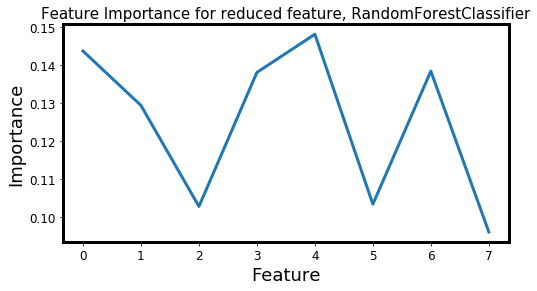

In [53]:
plt_title = 'Feature Importance for reduced feature, RandomForestClassifier'
x_label = 'Feature'
y_label = 'Importance'
fig = plt.figure()
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)
feature_importances = rfe.estimator_.feature_importances_
ax.plot(  np.arange(feature_importances.size) , feature_importances  )
#print(rfe.support_)
print(rfe.ranking_)

# Table of Comparision : 
in this section we gather the Scores from several Methods (Regression and Classification) used above 
and show them in a Table :

with Saved in ".npy" Format we stored 100000 Data 
in which some Algorithms Can't Process Quick Enough ! 

#### without Reduction :

Regression Methods :\begin{array}{rr} \hline
Regressor :  &LinearReg (degree = 4)  &Decision Tree Reg & Svr  \\ \hline
neg Mean Squared Error  :  & 0  & -3.041328\times10^{-6} + 1.261697\times10^{-7}  &TimeOut \\ \hline
\end{array}

Classification Methods :\begin{array}{rr} \hline
Classifier :  &Decision Tree  &Random Forest  &Ridge Classifier (degree =4) & Svc & Bayes & Sgd \\ \hline
neg Mean Squared Error :  & -0.228770+0.004596  & -0.134000+0.003466  &-0.318060+0.000027 & Timeout & -0.177160+0.003275 & -0.318060+0.000027 \\ \hline
\end{array} 

#### With reduction to 10Features:

Regression Methods :\begin{array}{rr} \hline
Regressor :  &LinearReg (degree = 4)  &Decision Tree Reg & Svr  \\ \hline
neg Mean Squared Error  :  & Score : 0.742  & -5.150108\times10^{-6} +3.257747e\times10^{-7}  &TimeOut \\ \hline
\end{array}
Classification Methods :\begin{array}{rr} \hline
Classifier :  &Ridge Classifier (degree =4)  &Sgd & Bayes & random Forest \\ \hline
neg Mean Squared Error :  & -0.318060+0.000027  & -0.318060+0.000027 &-0.254080+0.003834 & -0.214770+0.002714 \\ \hline
\end{array} 


